In [9]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from dotenv import load_dotenv
load_dotenv()

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "real_churn_sergey_sh_final"
RUN_NAME = "EDA"
REGISTRY_MODEL_NAME = "churn_model_sergey_sh"


ASSETS_DIR = "assets"

#os.mkdir(ASSETS_DIR)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64 

In [10]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,4,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.3,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,0
1,5,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.7,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1


/tmp/ipykernel_3348/1740526670.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);
/tmp/ipykernel_3348/1740526670.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(df[x].unique(), rotation = 45);
/tmp/ipykernel_3348/1740526670.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(df[x].unique(), rotation = 45);


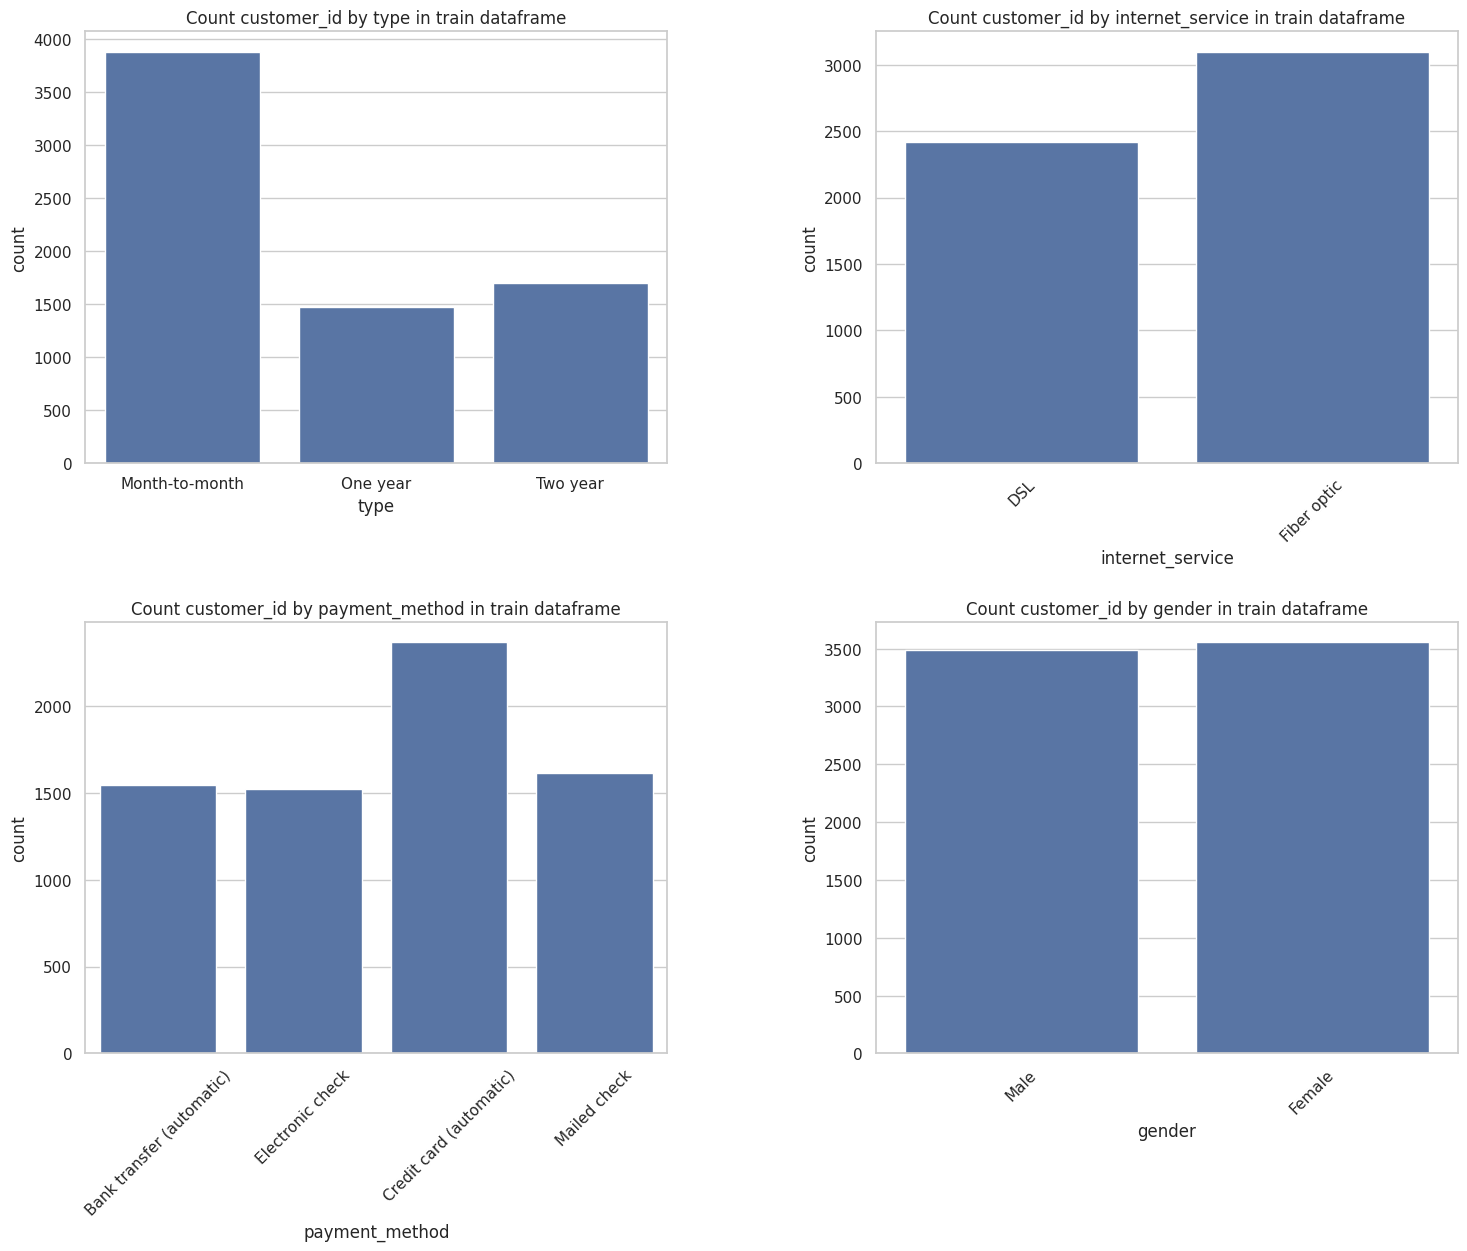

In [ ]:

b

In [ ]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ["count"]

print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv  \
0                No            No                No           No           No   
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

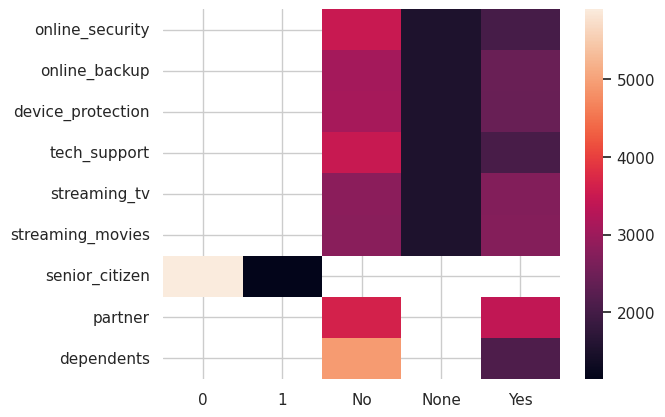

In [ ]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

/tmp/ipykernel_3348/192785167.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[charges_columns].dropna(inplace=True)


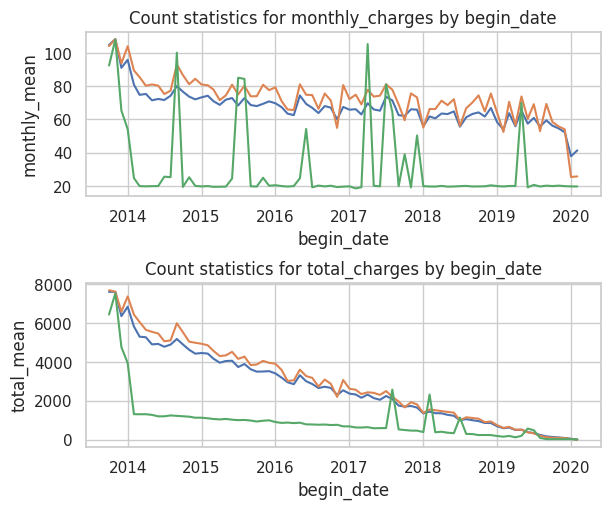

In [18]:
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df[charges_columns].dropna(inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].fillna(0).groupby([x]).agg(stats).reset_index() # ваш код здесь #

#удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].fillna(0).groupby([x]).agg(stats).reset_index()# ваш код здесь #
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2,1) # ваш код здесь #
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
# ваш код здесь #
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей

sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

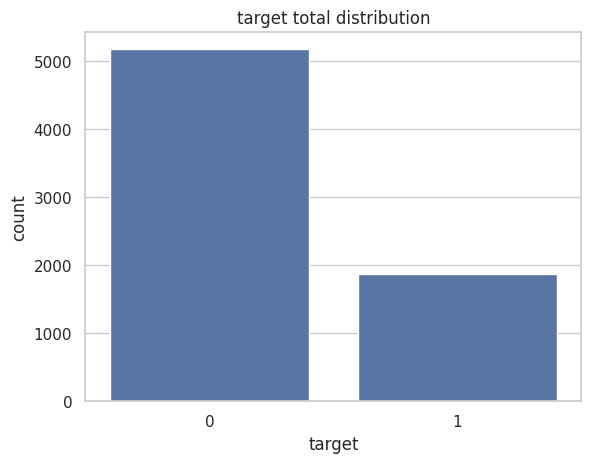

In [22]:
# директория для сохранения картинок
ASSETS_DIR = 'assets' # ваш код здесь #

# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index() # ваш код здесь #

# создание столбчатой диаграммы для визуализации распределения целевой переменной
# ваш код здесь #
sns.barplot(data=target_agg, x=x, y='count')
# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
# ваш код здесь #b

plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

In [24]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса

target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]
 
# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам

conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)


# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
  # ваш код здесь #
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)

In [26]:
target_agg_by_date.columns = [x, "target_count"]
target_agg_by_date.columns

Index(['begin_date', 'target_count'], dtype='object')

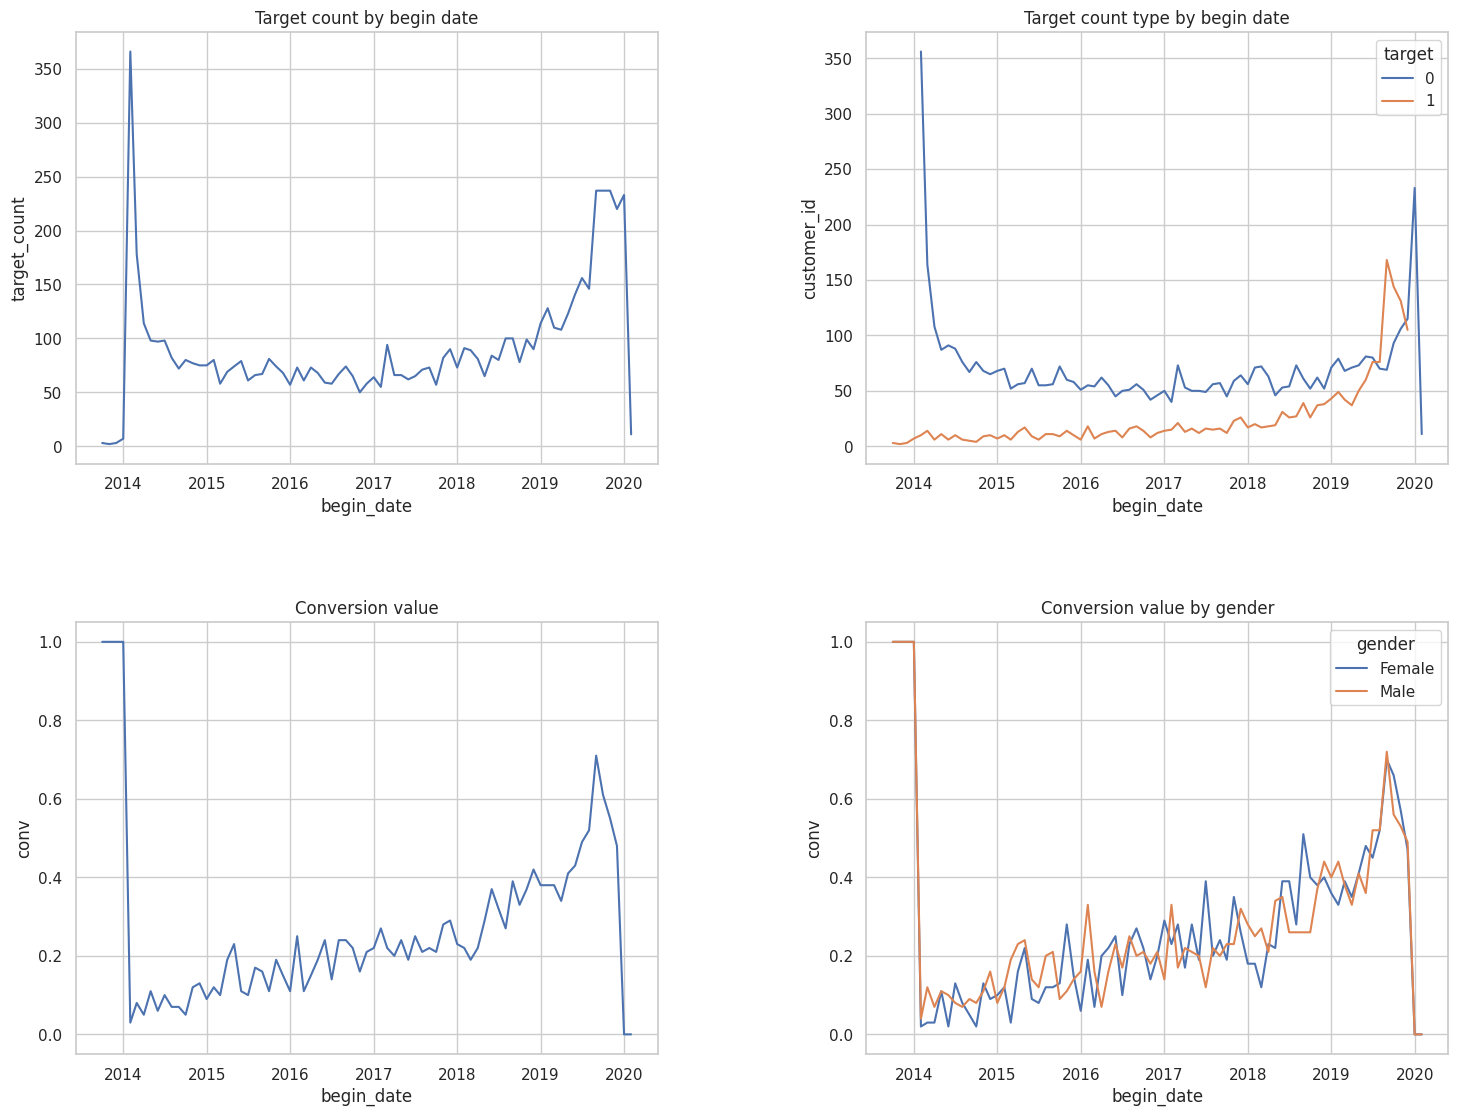

In [27]:

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
# ваш код здесь #
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
# ваш код здесь #
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
# ваш код здесь #
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
# ваш код здесь #
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

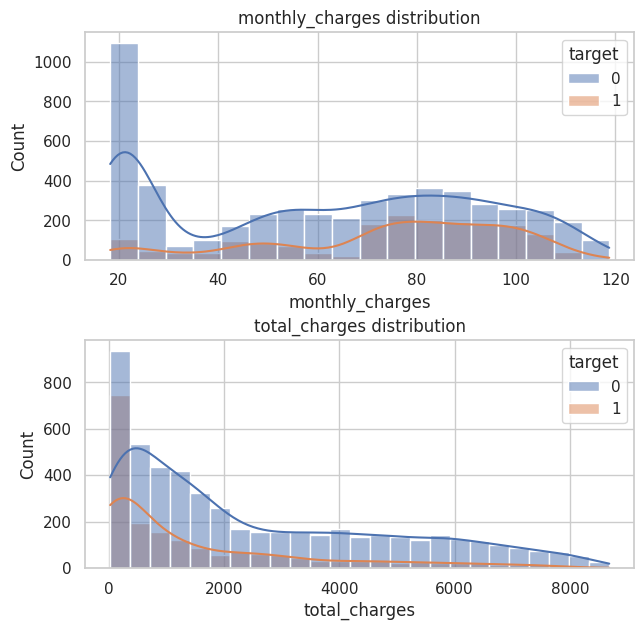

In [28]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм   
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])

# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
# ваш код здесь #
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [30]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)